## reuters 데이터셋에 LSTM 적용해보기

- reuters: IMDB 데이터셋과 같이 일련의 문장 모음으로 구성되어 있지만, 46개 카테고리로 이루어져 있는 다중분류 문제

In [1]:
# 데이터셋 사용하기

from tensorflow.keras.datasets import reuters

num_words = 10000
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words = num_words)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(8982,) (8982,)
(2246,) (2246,)


## 데이터를 동일한 길이로 맞추기

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 500

# 길이를 맞추기 위해 pad_sequences() 함수 사용
# 데이터가 지정해준 길이(max_len)보다 짧은 경우 0으로 채워넣으며 긴 경우는 잘라낸다.
pad_x_train = pad_sequences(x_train, maxlen = max_len)
pad_x_test = pad_sequences(x_test, maxlen = max_len)

## 학습을 위한 층 쌓기

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

model = Sequential()
model.add(Embedding(input_dim = num_words, output_dim = 64))
model.add(LSTM(64, return_sequences = True))
model.add(LSTM(32))
model.add(Dense(46, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 46)                1518      
Total params: 686,958
Trainable params: 686,958
Non-trainable params: 0
_________________________________________________________________


## 모델 학습하기

In [4]:
hist = model.fit(pad_x_train, y_train, batch_size = 32, epochs = 20, validation_split = 0.2)

# 학습 결과로 리턴된 history에서 확인할 수 있는 지표 출력
print(hist.history.keys())

Epoch 1/20
225/225 [==============================] - 102s 452ms/step - loss: 2.5563 - acc: 0.3509 - val_loss: 2.4096 - val_acc: 0.3450
Epoch 2/20
225/225 [==============================] - 99s 440ms/step - loss: 2.4075 - acc: 0.3534 - val_loss: 2.3752 - val_acc: 0.3450
Epoch 3/20
225/225 [==============================] - 101s 448ms/step - loss: 2.1173 - acc: 0.4547 - val_loss: 1.9990 - val_acc: 0.5058
Epoch 4/20
225/225 [==============================] - 101s 449ms/step - loss: 1.9163 - acc: 0.5105 - val_loss: 1.8574 - val_acc: 0.5220
Epoch 5/20
225/225 [==============================] - 102s 452ms/step - loss: 1.7606 - acc: 0.5420 - val_loss: 1.7036 - val_acc: 0.5554
Epoch 6/20
225/225 [==============================] - 101s 449ms/step - loss: 1.6576 - acc: 0.5695 - val_loss: 1.6692 - val_acc: 0.5776
Epoch 7/20
225/225 [==============================] - 103s 457ms/step - loss: 1.5655 - acc: 0.5922 - val_loss: 1.6032 - val_acc: 0.5888
Epoch 8/20
225/225 [=============================

## 모델 평가하기

In [5]:
model.evaluate(pad_x_test, y_test)

71/71 [==============================] - 9s 129ms/step - loss: 1.7511 - acc: 0.6144


[1.7510654926300049, 0.6144256591796875]

## 학습 과정 그리기

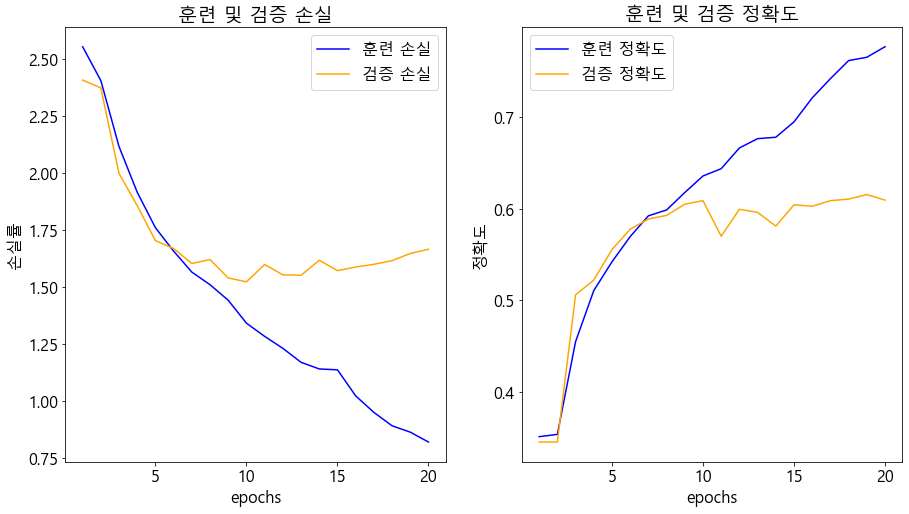

In [6]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (15, 8)

his_dict = hist.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure()

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = '훈련 손실')
ax1.plot(epochs, val_loss, color = 'orange', label = '검증 손실')
ax1.set_title('훈련 및 검증 손실')
ax1.set_xlabel('epochs')
ax1.set_ylabel('손실률')
ax1.legend()

# 훈련 및 검증 정확도 그리기
acc = his_dict['acc']
val_acc = his_dict['val_acc']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = '훈련 정확도')
ax2.plot(epochs, val_acc, color = 'orange', label = '검증 정확도')
ax2.set_title('훈련 및 검증 정확도')
ax2.set_xlabel('epochs')
ax2.set_ylabel('정확도')
ax2.legend()

plt.show()

## 함수 정의하기

In [7]:
import numpy as np

# 뉴스 기사와 라벨 데이터를 벡터로 변환
def vectorize_sequences(sequences, dimension = 10000):
    results = np.zeros((len(sequences), dimension))
    # 크기가 들어온 리스트(단어개수, 전체단어개수)이고, 모든 원소가 0인 행렬을 생성
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

## 모델을 이용해 각 뉴스기사에 대한 토픽을 예측하기
- softmax를 사용하여 각 뉴스별로 46개의 토픽에 해당하는 확률을 출력
    - 각 클래스별 확률을 모두 더하면 1.0(100%)가 된다.

In [8]:
from tensorflow.keras.utils import to_categorical

# 준비한 함수를 활용하여 훈련, 테스트 데이터를 학습 데이터와 레이블로 분류함.
x_train = vectorize_sequences(x_train)
x_test = vectorize_sequences(x_test)

one_hot_train_labels = to_categorical(y_train)
one_hot_test_labels = to_categorical(y_test)

In [9]:
predictions = model.predict(x_test)

## 결과
- (2246, 46)
- predictions는 테스트 데이터셋의 개수에 맞게 2246개의 결과가 들어 있다.
- 각 결과 안에는 46개 클래스에 해당하는 확률값이 들어가 있다.

In [10]:
display(predictions.shape)

(2246, 46)

In [11]:
# predictions[0]의 44번째 인덱스가 가장 큰 값을 가지는 것을 확인. -> 실패ㅠㅠ
print(np.argmax(predictions[0]))

45
